# 1. Load Data

In [1]:
# import library
import os
import glob
import pandas as pd
import numpy as np
import re
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import itertools

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import EasyEnsemble, BalanceCascade
from imblearn.datasets import make_imbalance
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

# change working directory
path = r'C:\Users\LW130003\Desktop\New folder\SentenceCorpus'
os.chdir(path)

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1.1 Unlabeled articles

In [2]:
def load_labeled():
    """
    This function load all the labeled text files and automatically 
    extract information from the filename
    """
    # inner function
    def load_text():
        # this function loads text file and extract info from filename
        # return: texts (in list), Domain, Article_Id, Annotator

        file_list = glob.glob(os.path.join(os.getcwd(), "labeled_articles", "*.txt"))
    
        corpus = []
        domain = []
        article_id = []
        annotator = []
    
        for file_path in file_list:
            filename = os.path.basename(file_path).split('_')
            domain.append(filename[0])
            article_id.append(filename[2])
            annotator.append(filename[3].split('.')[0])
            with open(file_path) as f_input:
                corpus.append(f_input.read())
        
        return corpus, domain, article_id, annotator
    
    def to_df(string, domain, ID, annot):    
        # this function transform a text into a Dataframe which include the domain, article_id, annotator
        # inputs: text(string), domain of text, article_id, annotator

        # split into 2 types: texts found in abstract and introduction and split the labels and texts    
        abs_no = string.find('### abstract ###')
        intro_no = string.find('### introduction ###')
        abs1 = string[abs_no+len('### abstract ###')+1:intro_no].split('\n')
        intro1 = string[intro_no+len('### introduction ###')+1:].split('\n')
        
        abstract = []
        introduction = []
        # separate labels and text
        for idx, val in enumerate(abs1):
            val = val.split('\t')
            abstract.append(val)
        for idx, val in enumerate(intro1):
            val = val.split('\t')
            introduction.append(val)
        # create dataframe
        abstract = pd.DataFrame(abstract)
        abstract['type'] = 'abstract'
    
        introduction = pd.DataFrame(introduction)
        introduction['type'] = 'introduction'

        # combine abstract and introduction into one
        data = pd.concat([abstract, introduction])
    
        # rename column 0 -> labels and column 1 -> texts
        data.rename(columns={0: "labels", 1: "texts"}, inplace=True)
    
        # add domain, article_id, annotation
        data['domain'] = domain
        data['article_id'] = ID
        data['annotator'] = annot
    
        return data

    # this function load dataset that will be used for training ML model    
    dataframe = pd.DataFrame()
    corpus, domain, article_id, annotator = load_text()    
    # error checking length of corpus, domain, article_id, annotator must be equal
    if len(corpus) == len(domain) == len(article_id) == len(annotator):
        for i in range(len(corpus)):
            dataset = to_df(corpus[i], domain[i], article_id[i], annotator[i])
            dataframe = dataframe.append(dataset, ignore_index = True)  
    else:
        print('lengths are not equal, there might some problem in load_text()')
        
    return dataframe

In [3]:
# load labeled_articles
labeled = load_labeled()
labeled.describe(include=['O'])

,annotator,article_id,domain,labels,texts,type,2
count,3268,3268,3268,3268,1510,3268,1
unique,3,30,3,1210,1151,2,1
top,3,120,plos,MISC,They are limited by of order 100 ns time scale...,introduction,characterize the composing ases
freq,1095,236,1162,852,2,2575,1


Here we could observe, that there are errors in separating the code due to extra space in text document. First, I will check the data that have values in column 2 and fix the typo.

In [4]:
# check the data that has value in row 2
labeled[labeled[2].notnull()]

,annotator,article_id,domain,labels,texts,type,2
220,1,13,arxiv,MISC,since there is such a diversity among differen...,introduction,characterize the composing ases


In [5]:
print(labeled.loc[220, 2])
print(labeled.loc[220,'texts'])

characterize the composing ases
since there is such a diversity among different network types  we cannot accurately augment the as level topology with appropriate router level topologies if we cannot MISC


Since there are only 1 problem. Let's just append it to the end of data and edit the typo.

In [6]:
labeled.loc[220,'texts'] = 'since there is such a diversity among different network types  we cannot accurately augment the as level topology with appropriate router level topologies if we cannot'
labeled.drop(columns=2, inplace=True)
# append the data at the end of dataset
labeled.loc[labeled.shape[0]+1] = ['1', '13', 'arxiv', 'MISC', 'characterize the composing ases', 'introduction']
# check if the fix has been applied
print(labeled.loc[220,'texts'], '\n\n', labeled.tail(1))

since there is such a diversity among different network types  we cannot accurately augment the as level topology with appropriate router level topologies if we cannot 

      annotator article_id domain labels                            texts  \
3269         1         13  arxiv   MISC  characterize the composing ases   

              type  
3269  introduction  


Next is to fix the row where the text are still connected with the labels. Luckily, Luckyly, all the labels are 4 letter words. Therefore, it is possible fix the problem by slicing the first 4 letters to 'label' column and 5th to end letters to 'text' column.

In [7]:
# get the index of the rows with problem 1
prob_idx = labeled[labeled['texts'].isnull()].index.tolist()
# loop reimpute the data
for idx in prob_idx:
    labeled.loc[idx,'texts'] = labeled.loc[idx,'labels'][5:]
    labeled.loc[idx,'labels'] = labeled.loc[idx,'labels'][0:4]
# check the data
print('Number of missing texts: {}'.format(labeled['texts'].isnull().sum()))

Number of missing texts: 0


Summarize data again

In [8]:
labeled.describe(include=['O'])

,annotator,article_id,domain,labels,texts,type
count,3269,3269,3269,3269,3269,3269
unique,3,30,3,7,1415,2
top,3,120,plos,MISC,,introduction
freq,1095,236,1162,1826,151,2576


From data description, it is observed that althought there should be no missing value as there are no missing count, there are 7 types of labels and the largest number of text is '' which is quite strange. Let's print the unique labels and data with empty text.

In [9]:
# data unique labels
labeled['labels'].unique()

array(['MISC', 'AIMX', 'OWNX', '', 'CONT', 'BASE', 'OWNX '], dtype=object)

In [10]:
# data with empty labels
print(labeled[labeled['labels']==''].head())

# data with empty text
print(labeled[labeled['texts']==''].head())

    annotator article_id domain labels texts          type
7           1          7  arxiv                   abstract
75          2          7  arxiv                   abstract
143         3          7  arxiv                   abstract
210         1         13  arxiv                   abstract
239         1         13  arxiv               introduction
    annotator article_id domain labels texts          type
7           1          7  arxiv                   abstract
75          2          7  arxiv                   abstract
143         3          7  arxiv                   abstract
210         1         13  arxiv                   abstract
239         1         13  arxiv               introduction


For confirmation, let's check if data with empty labels and empty texts are all from the same index

In [11]:
labeled[labeled['labels']==''].index == labeled[labeled['texts']==''].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Above, we could see that data with missing texts and labels are from the same rows. Based on this it could be concluded that most likely the rows of data are created due to extra spacing.

Next, from the unique labels it could be seen there are labels 'OWNX ' which should be 'OWNX'. This problems may occur due to spacing error too. 

Let's fix these typo by reimpute the data and drop the missing rows.

In [12]:
# drop rows
idx = labeled[labeled['labels']==''].index
labeled.drop(index=idx, inplace=True)
# reset index after dropping the rows
labeled.reset_index(drop=True, inplace=True)

# reimpute the data
labeled.loc[labeled['labels']=='OWNX ','labels'] = 'OWNX'
# check if the fixes have been applied
labeled['labels'].unique()

array(['MISC', 'AIMX', 'OWNX', 'CONT', 'BASE'], dtype=object)

In [13]:
# check missing values and duplicated
print('Number of missing values: {}'.format(labeled.isnull().sum()))
print('Number of duplicates: {}'.format(labeled.duplicated().sum()))

Number of missing values: annotator     0
article_id    0
domain        0
labels        0
texts         0
type          0
dtype: int64
Number of duplicates: 0


In [14]:
# summary statistics again
labeled.describe(include=['O'])

,annotator,article_id,domain,labels,texts,type
count,3118,3118,3118,3118,3118,3118
unique,3,30,3,5,1414,2
top,1,120,plos,MISC,We prove novel and distinct stability-based ge...,introduction
freq,1040,231,1113,1826,4,2515


In [15]:
## 1.2 Unlabeled articles

In [16]:
def load_unlabeled():
    """
    This function load all the unlabeled articles and extract information from the filename
    """
    def load_text():
        # this function loads text file
        # return: texts (in list), Domain, Article_Id
        article_id = []
        domain = []
        corpus = []
        publishers = ['arxiv', 'jdm', 'plos']

        for source in publishers:
            file_list = glob.glob(os.path.join(os.getcwd(), "unlabeled_articles", 
                                               source + "_unlabeled","*.txt"))
            
            for file_path in file_list:
                article_id.append(os.path.basename(file_path).split('.')[0])
                domain.append(source)
            
                # encoding 'utf-8' can't decode all, so read with binary and decode it back to 'utf-8'
                with open(file_path, 'rb') as f_input:
                    corpus.append(f_input.read().decode('utf8', 'ignore'))
                    
        return corpus, domain, article_id
    
    def to_df(string, domain, ID):    
        # this function transform a text into a Dataframe which include the domain, article_id, annotator
        # inputs: text(string), domain of text, article_id, annotator
        # note to_df function here is different from to_df function in load_labeled()

        # split into 2 types: texts found in abstract and introduction and split the labels and texts    
        abs_no = string.find('### abstract ###')
        intro_no = string.find('### introduction ###')
        abstract = string[abs_no+len('### abstract ###')+1:intro_no].split('\n')
        introduction = string[intro_no+len('### introduction ###')+1:].split('\n')
        # create dataframe
        abstract = pd.DataFrame(abstract)
        abstract['type'] = 'abstract'
    
        introduction = pd.DataFrame(introduction)
        introduction['type'] = 'introduction'

        # combine abstract and introduction into one
        data = pd.concat([abstract, introduction])
    
        # rename column 0 -> texts
        data.rename(columns={0: "texts"}, inplace=True)
    
        # add domain, article_id, annotation
        data['domain'] = domain
        data['article_id'] = ID
    
        return data

    # this function load dataset that will be used for training ML model    
    dataframe = pd.DataFrame()
    corpus, domain, article_id = load_text()    
    # error checking length of corpus, domain, article_id, annotator must be equal
    if len(corpus) == len(domain) == len(article_id):
        for i in range(len(corpus)):
            dataset = to_df(corpus[i], domain[i], article_id[i])
            dataframe = dataframe.append(dataset, ignore_index = True)  
    else:
        print('lengths are not equal, there might some problem in load_text()')
        
    return dataframe

In [17]:
unlabeled = load_unlabeled()
unlabeled.tail()

,texts,type,domain,article_id
36422,"Moreover, in humans, in the absence of of FORM...",introduction,plos,995
36423,To assess the contributions of thymic emigrati...,introduction,plos,995
36424,It may be of importance to note that the thymu...,introduction,plos,995
36425,"In humans, transplantation of thymic tissue at...",introduction,plos,995
36426,,introduction,plos,995


In [18]:
# drop empty text due to extra spacing
un_idx = unlabeled[unlabeled['texts']==''].index
unlabeled.drop(index=un_idx, inplace=True)
# reset the index after dropping the empty rows
unlabeled.reset_index(drop=True, inplace=True)
unlabeled.tail()

,texts,type,domain,article_id
34590,This phenomenon is presumably attributable to ...,introduction,plos,995
34591,"Moreover, in humans, in the absence of of FORM...",introduction,plos,995
34592,To assess the contributions of thymic emigrati...,introduction,plos,995
34593,It may be of importance to note that the thymu...,introduction,plos,995
34594,"In humans, transplantation of thymic tissue at...",introduction,plos,995


In [19]:
# check missing values and duplicated
print('Number of missing values: {}'.format(unlabeled.isnull().sum()))
print('Number of duplicates: {}'.format(unlabeled.duplicated().sum()))

Number of missing values: texts         0
type          0
domain        0
article_id    0
dtype: int64
Number of duplicates: 14


In [20]:
# summary statistics
unlabeled.describe(include=['O'])

,texts,type,domain,article_id
count,34595,34595,34595,34595
unique,34327,2,3,580
top,The paper is organized as follows,introduction,plos,235
freq,17,27845,12878,356


There are 14 duplicates, but since this is a test data. I don't think we should drop the duplicates.

## 1.3 Word lists

In [21]:
def load_dict():
    """
    this function load word_list to dictionary.
    word_list will be used for stopwords and decision tree modeling
    """
    Dictionary = dict()
    file_list = ['aim', 'base', 'contrast', 'own', 'stopwords']
    for file_name in file_list:
        Dictionary[file_name] = open(os.path.join(os.getcwd(), "word_lists", file_name+".txt")).read().split()
    
    return Dictionary

In [22]:
# load and print word_lists
dictionary = load_dict()
print('Stopwords\n', dictionary['stopwords'], '\n','-'*70)
print('Aim\n', dictionary['aim'], '\n','-'*70)
print('Base\n', dictionary['base'], '\n','-'*70)
print('Contrast\n', dictionary['contrast'], '\n','-'*70)
print('Own\n', dictionary['own'])

Stopwords
 ['of', 'a', 'and', 'the', 'in', 'to', 'for', 'that', 'is', 'on', 'are', 'with', 'as', 'by', 'be', 'an', 'which', 'it', 'from', 'or', 'can', 'have', 'these', 'has', 'such'] 
 ----------------------------------------------------------------------
Aim
 ['we', 'this', 'paper', 'study', 'show', 'present', 'new', 'model', 'introduce', 'current', 'investigated', 'compare', 'designed', 'argue', 'examines', 'propose', 'interested', 'address', 'give', 'discuss', 'discover', 'how', 'identification', 'developed', 'influences', 'main', 'goal', 'motivate', 'establish', 'applied', 'formalize', 'assess', 'purpose', 'examine', 'to', 'survey', 'use', 'have', 'investigation', 'investigate', 'validate', 'influence', 'make', 'answer', 'suggest', 'work', 'analyze', 'investigates', 'theoretical', 'was', 'concentrate', 'approach'] 
 ----------------------------------------------------------------------
Base
 ['using', 'extend', 'relies', 'spirit', 'previously', 'foundation', 'on', 'reuse', 'similar

after checking the dictionary it could be observed that:
1. Many of the keywords are not in based form. For example, there are *apply* in 'Own' and *applied* in 'Aim' in dictionary. Hence the 'texts' should not be stemmed or lemmatized as it may obscure the purpose of the words.
2. It could be observed that there are few words that are exists in multiple dictionary example, 'we' and 'answer' in  both 'Aim' and 'Own'. This imply, we may need to use gini index in constructing decision trees.
3. All the words inside dictionary are in lower case, thus all words in 'texts' need to be transformed to lower case too.

Also, according to the text document in "Annotation procedure" section, that two of three annotators were not likely to be experts in the scientific domain, nor they experts in the task of annotating sentences. Only the third annotators, in contrast, did have training in annoting sentences according to AZ. Hence, with this reason we will only analyzed the texts from annotator 3.

In [23]:
labeled3 = labeled[labeled.annotator == '3']
# reset index
labeled3.reset_index(drop=True, inplace=True)

# 2. Natural Language Processing

In [24]:
def tokenize(sentence):
    # this function will tokenize, the input must be string
    
    # remove punctuation
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
    # lower case strings
    sentence = sentence.lower()
    # tokenize with nltk
    sentence = nltk.word_tokenize(sentence)
    return sentence

def stopwordsremoval(sentence, stopwords):
    # this function removes the words in 'sentence' that are in 'stopwords'
    # input 'sentence' and 'stopwords' must be a list of strings
    # note: stopwords are list of words we need to remove
    
    # create a copy of sentence2 for looping
    sentence2 = sentence.copy()
    for word1 in sentence2:
        for word2 in stopwords:
            if word1 == word2:
                sentence.remove(word2)

    return sentence

def preprocess(data, stopwords):
    # this function create several metadata and NLP the text
    # Note: this function does not lemmatize and vectorize the text
    
    # reset index: this function is index sensitve
    data.reset_index(drop=True, inplace=True)
    
    # Creating metada
    
    # Number of words in the text 
    data.loc[:,'num_words'] = data.texts.apply(lambda x: len(str(x).split()))
    # Number of unique words in the text
    data.loc[:,"num_unique_words"] = data.texts.apply(lambda x: len(set(str(x).split())))
    # Number of characters in the text
    data.loc[:,"num_chars"] = data.texts.apply(lambda x: len(str(x)))
    # Number of punctuations in the text 
    data.loc[:,"num_punctuations"] = data.texts.apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
    # Number of upper case words in the text
    data.loc[:,"num_words_upper"] = data.texts.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    # Average length of the words in the text
    data.loc[:,'mean_word_len'] = data.texts.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # Number of stopwords in the text
    data.loc[:,'num_stopwords'] = labeled.texts.apply(lambda x: len([w for w in str(x).lower().split() if w in dictionary['stopwords']]))
    
    # Natural Language Processing
    for idx, sentence in enumerate(data.texts):
        temp = data.loc[idx, 'texts']
        temp = tokenize(temp)
        temp = stopwordsremoval(temp, stopwords)
        data.loc[idx,'text_cleaned'] = ' '.join(temp)
    
    return data

In [25]:
# preprocess labeled
labeled3 = preprocess(labeled3, dictionary['stopwords'])

# preprocess unlabeled
unlabeled = preprocess(unlabeled, dictionary['stopwords'])

C:\Users\LW130003\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\LW130003\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\LW130003\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [26]:
# 3. Data Visualization
## 3.1 Bar Plot

C:\Users\LW130003\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


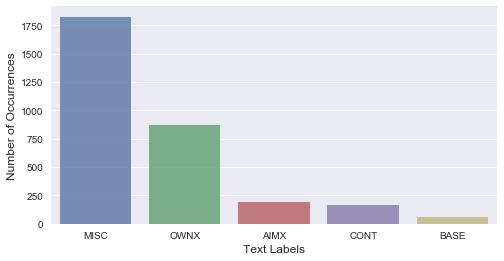

In [27]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

count = labeled['labels'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(count.index, count.values, alpha=0.8);
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Text Labels', fontsize=12)

This is an imbalanced multi - classification data problem.

In [28]:
def check_dist(data):
    """
    This function: 
    - counts and print the distribution of labels
    - counts and print data length
    """
    Count_OWNX = len(data[data['labels']=='OWNX'])
    Count_AIMX = len(data[data['labels']=='AIMX'])
    Count_CONT = len(data[data['labels']=='CONT'])
    Count_BASE = len(data[data['labels']=='BASE'])
    Count_MISC = len(data[data['labels']=='MISC'])
    total = Count_OWNX+Count_AIMX+Count_CONT+Count_BASE+Count_MISC
    Percent_OWNX = Count_OWNX/(total)*100
    Percent_AIMX = Count_AIMX/(total)*100
    Percent_CONT = Count_CONT/(total)*100
    Percent_BASE = Count_BASE/(total)*100
    Percent_MISC = Count_MISC/(total)*100
    print('Distribution for dataset')
    print('The Distribution of labels: \n\tOWNX: {:.2f}% \n\tAIMX: {:.2f}% \n\tCONT: {:.2f}% \n\tBASE: {:.2f}% \n\tMISC: {:.2f}%'.format(Percent_OWNX, Percent_AIMX, Percent_CONT, Percent_BASE, Percent_MISC))
    print('\nData lengths: \n\tTotal: {}, \n\tOWNX: {} \n\tAIMX: {} \n\tCONT: {} \n\tBASE: {} \n\tMISC: {}'.format(total, Count_OWNX, Count_AIMX, Count_CONT, Count_BASE, Count_MISC))

In [29]:
# check distribution
check_dist(labeled3)

Distribution for dataset
The Distribution of labels: 
	OWNX: 27.91% 
	AIMX: 6.16% 
	CONT: 4.33% 
	BASE: 1.44% 
	MISC: 60.15%

Data lengths: 
	Total: 1039, 
	OWNX: 290 
	AIMX: 64 
	CONT: 45 
	BASE: 15 
	MISC: 625


## 3.2 Frequency Distribution Plot

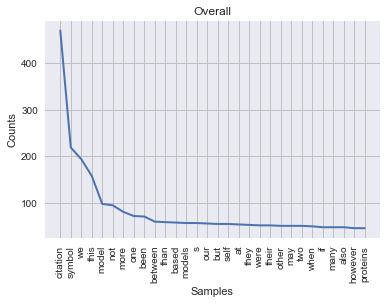

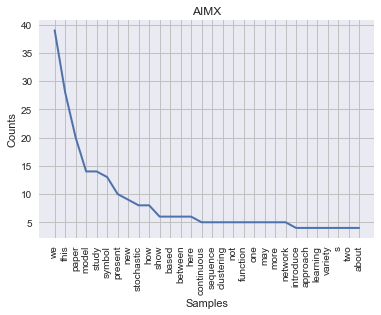

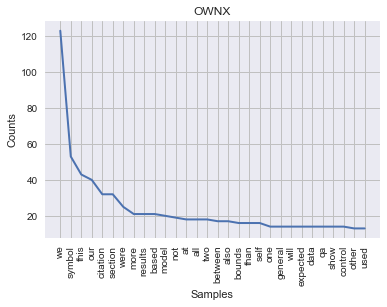

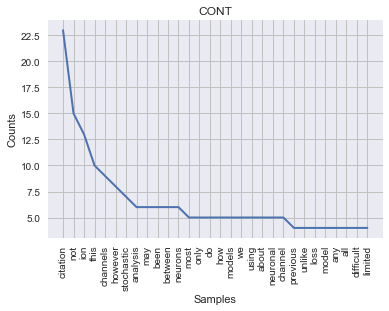

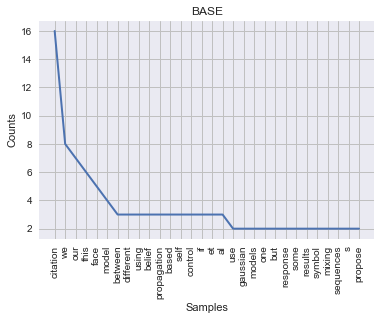

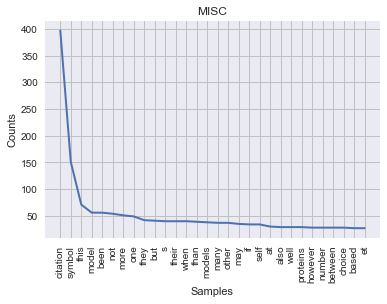

In [30]:
aimx = labeled3.loc[labeled3['labels'] == 'AIMX']
ownx = labeled3.loc[labeled3['labels'] == 'OWNX']
cont = labeled3.loc[labeled3['labels'] == 'CONT']
base = labeled3.loc[labeled3['labels'] == 'BASE']
misc = labeled3.loc[labeled3['labels'] == 'MISC']

aimx_t = aimx.text_cleaned
ownx_t = ownx.text_cleaned
cont_t = cont.text_cleaned
base_t = base.text_cleaned
misc_t = misc.text_cleaned

# plot frequencies
fd = nltk.FreqDist([y for x in labeled3.text_cleaned.str.split() for y in x])

fd_aimx = nltk.FreqDist([y for x in aimx_t.str.split() for y in x])
fd_ownx = nltk.FreqDist([y for x in ownx_t.str.split() for y in x])
fd_cont = nltk.FreqDist([y for x in cont_t.str.split() for y in x])
fd_base = nltk.FreqDist([y for x in base_t.str.split() for y in x])
fd_misc = nltk.FreqDist([y for x in misc_t.str.split() for y in x])

fd.plot(30, title='Overall')

fd_aimx.plot(30, title='AIMX')
fd_ownx.plot(30, title='OWNX')
fd_cont.plot(30, title='CONT')
fd_base.plot(30, title='BASE')
fd_misc.plot(30, title='MISC')

## 3.3 Wordclouds

Print the word cloud to visualize the top words frequency.

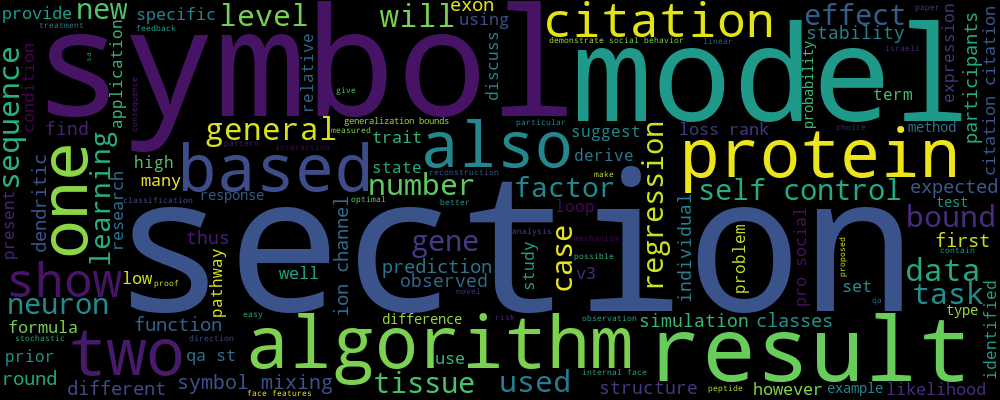

In [31]:
sns.set_style({'axes.grid' : False})
# OWNx
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(ownx_t)).to_image()

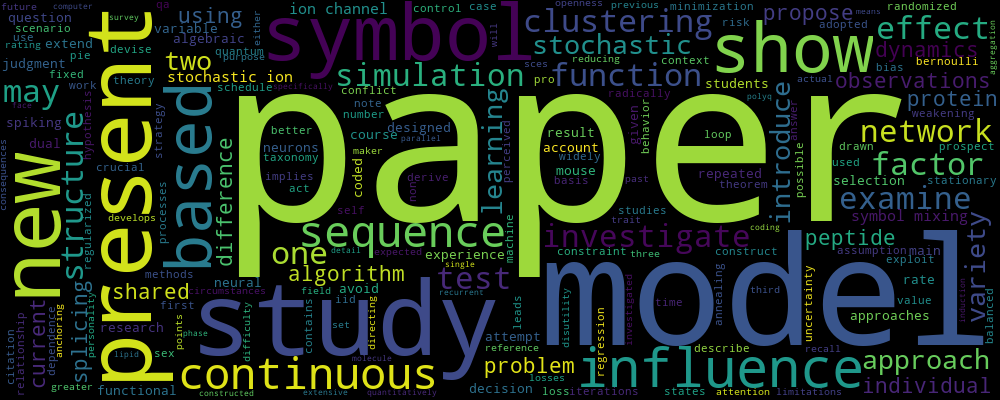

In [32]:
# AIMX
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(aimx_t)).to_image()

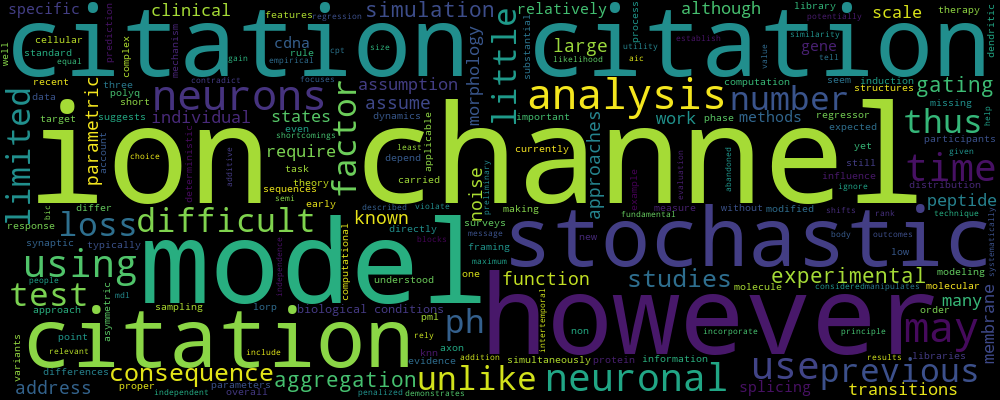

In [33]:
# Cont
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(cont_t)).to_image()

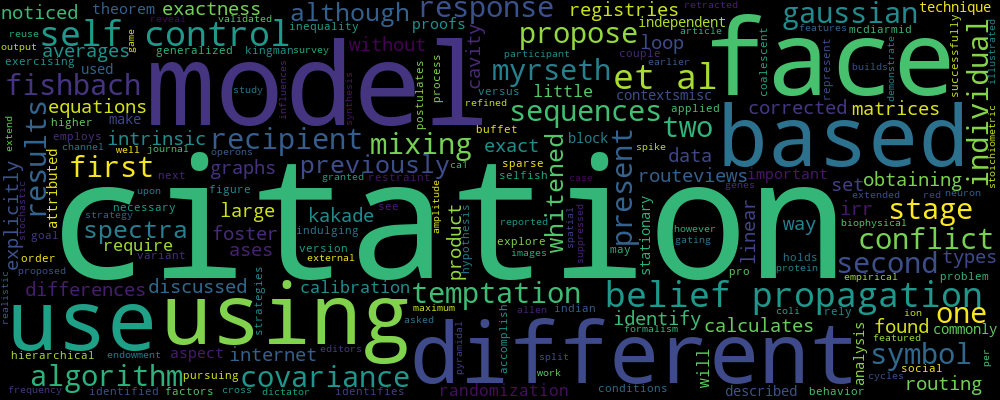

In [34]:
# Base
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(base_t)).to_image()

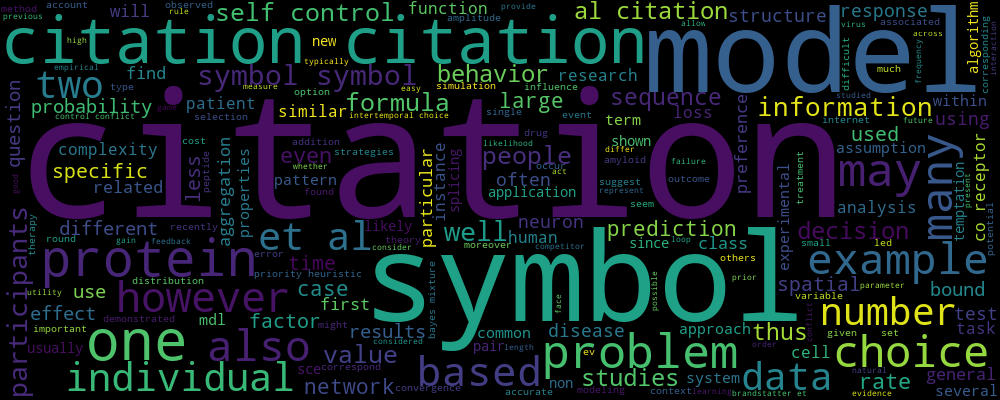

In [35]:
# MISC
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(misc_t)).to_image()

## 3.4 Meta-features distribution

In [36]:
def drop_outliers(s):
    """
    this function is used to drop outliers.
    outliers is assumed outside the std range 
    """
    m = s.mean()
    std = s.std()
    return s[(m - 3*std <= s) & (s <= m + 3*std)]

def plot_metafeatures(data):
    """
    This function plots metafeatures that are created in preprocessing
    """
    sns.set()
    metafeatures = ['num_words', 'num_unique_words', 'num_chars', 'num_punctuations', 
        'num_words_upper', 'mean_word_len', 'num_stopwords']
    for meta in metafeatures:
        f, ax = plt.subplots(figsize=(7,4))
        sns.kdeplot(drop_outliers(aimx[meta]), shade=True, color='r')
        sns.kdeplot(drop_outliers(ownx[meta]), shade=True, color='b')
        sns.kdeplot(drop_outliers(cont[meta]), shade=True, color='g')
        sns.kdeplot(drop_outliers(base[meta]), shade=True, color='w')
        sns.kdeplot(drop_outliers(misc[meta]), shade=True, color='y')
        ax.legend(labels=['AIMX', 'OWNX', 'CONT', 'BASE', 'MISC'])
        ax.set_title(meta);

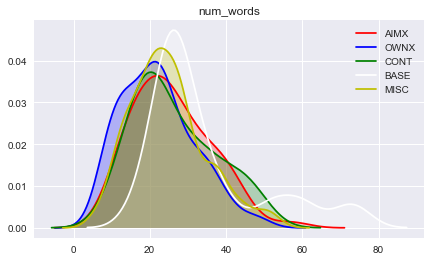

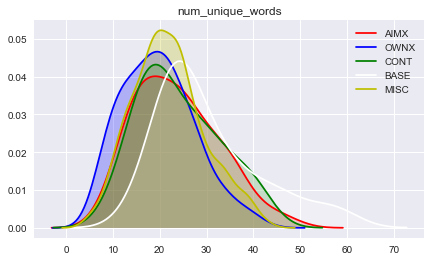

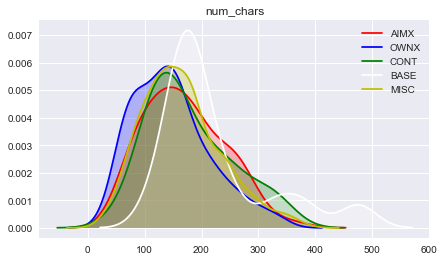

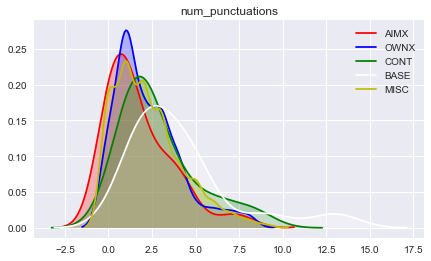

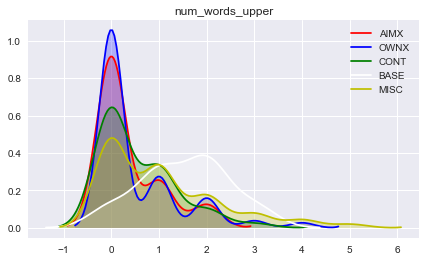

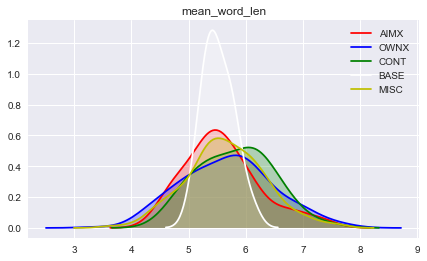

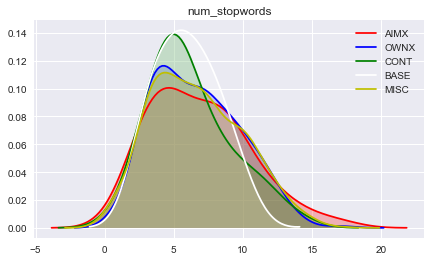

In [37]:
# plot metafeatures in labeled data set
plot_metafeatures(labeled)

# 4. Imabalanced Multi-Class Problem

Based on plot in section 3.3, we plot it again below. This is most likely an imbalanced data problem. In this section, we will vectorize the text and apply machine learning algorithm from sklearn. 

According to MachineLearningMastery, there are many ways to handle imbalanced datasets such as:
1. Collecting more data
2. Changing your performance metric
3. Resampling the dataset
4. Generate synthetic samples
5. Try different algorithm
6. Try Penalized model
7. Try a different perspective
8. Try getting creative

Classification_report_imb build a classification report based on metrics used with imbalanced dataset:
- **Precision**/Positive Predictive Values: $PPV = \frac{TP}{TP+FP}$
- **Recall**/Sensitivity/True Positive Rates: $TPR = \frac{TP}{TP+FN}$
- **Specificity**/True Negative Rates: $TNR = \frac{TN}{TN+FP}$
- **F1 Score**: is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.
- **Geometric Mean**: measures the central tendecy.
- **Index Balanced Accuracy**: average of the proportion corrects of ecah class individually. IBA = accuracy if the class is balanced.
- **Support** is the number of occurrences of each class in validation sets.


**Notes1:**
- **TP** = True positive = number of positive cases which are predicted positive
- **TN** = True negative = number of negative cases which are predicted negative
- **FP** = False positive = number of negative cases which are predicted positive
- **FN** = False positive = number of positive cases which are predicted negative

**Note2**: some think that oversampling is superior because it results in more data, whereas undersampling throws away the data. But replicating data is not without consequence - since it results in duplicate data, it makes variables appear to have lower variance than they do. The positive consequence is that it duplicates the number of errors: If a classifier makes a false neative error on the original minority data set, and that data set is replicated five times, the classifier will make six errors on the new set. Conversely, undersampling can make the independent variables look like they have a higher variance than they do.

In [38]:
# One Hot Encoding
remap1 = {'OWNX': 0, 'AIMX': 1, 'CONT': 2, 'BASE': 3, 'MISC': 4}
remap2 = {'abstract': 0, 'introduction': 1}
remap3 = {'arxiv': 0, 'jdm': 1, 'plos': 2}

# labeled['labels'].replace(remap1, inplace=True)
labeled3['labels'].replace(remap1, inplace=True)
labeled3['type'].replace(remap2, inplace=True)
labeled3['domain'].replace(remap3, inplace=True)

unlabeled['type'].replace(remap2, inplace=True)
unlabeled['domain'].replace(remap3, inplace=True)

C:\Users\LW130003\Anaconda3\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## 4.1 Vectorization, Resampling and Machine Learning

In [39]:
# make_pipeline from sklearn vs make_pipeline from imblearn
RANDOM_STATE = 2018
X = labeled3.drop(columns = ['texts', 'labels'])
y = labeled3['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE)

print('Training class distributions summary: {}'.format(Counter(y_train)))
print('Test class distributions summary: {}'.format(Counter(y_test)))

# Usual Pipeline
pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())
pipe.fit(X_train.text_cleaned, y_train)
y_pred = pipe.predict(X_test.text_cleaned)
print(classification_report_imbalanced(y_test, y_pred))

# Balancing before classification
pipe = make_pipeline_imb(TfidfVectorizer(),
                         RandomUnderSampler(),
                         MultinomialNB())

pipe.fit(X_train.text_cleaned, y_train)
y_pred = pipe.predict(X_test.text_cleaned)
print(classification_report_imbalanced(y_test, y_pred))

Training class distributions summary: Counter({4: 471, 0: 216, 1: 49, 2: 30, 3: 13})
Test class distributions summary: Counter({4: 154, 0: 74, 2: 15, 1: 15, 3: 2})
                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.15      0.98      0.25      0.76      0.59        74
          1       0.00      0.00      1.00      0.00      0.00      0.00        15
          2       0.00      0.00      1.00      0.00      0.00      0.00        15
          3       0.00      0.00      1.00      0.00      0.00      0.00         2
          4       0.62      0.99      0.12      0.77      0.76      0.56       154

avg / total       0.59      0.63      0.48      0.52      0.67      0.50       260



C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\LW130003\Anaconda3\lib\site-packages\imblearn\metrics\classification.py:244: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


                   pre       rec       spe        f1       geo       iba       sup

          0       0.40      0.24      0.85      0.30      0.54      0.29        74
          1       0.20      0.53      0.87      0.29      0.43      0.17        15
          2       0.19      0.60      0.84      0.29      0.43      0.17        15
          3       0.02      1.00      0.67      0.05      0.15      0.02         2
          4       0.70      0.18      0.89      0.29      0.55      0.31       154

avg / total       0.55      0.25      0.87      0.29      0.53      0.28       260



Here, we could observe that balancing the data improve the machine learning algorithm. Next, we will attempt several resampling function and find which one is the best for us to use.
- **Undersample**: ClusterCentroids, RandomUnderSampler, NearMiss
- **Oversample**: ADASYN, SMOTE, RandomOverSampler
- **Mixed**: SMOTEN, SMOTETomek
- **Ensemble**: EasyEnsemble, BalanceCascade

**Note**: In mixed resample, generally SMOTE is used for over-sampling while some cleaning methods (i.e., ENN and Tomek links are used to under-sample.
- SMOTEN = SMOTE + Edited Nearest Neighbours
- SMOTETomek = SMOTE + Tomek

In [40]:
def test_resampler(estimator, vectorizer, RANDOM_STATE = 2018):
    """
    This function will test oversample, undersample and mixed sample methods and print the
    imbalanced classifcation reports.
    """
    # Resamplers
    oversamplers = [RandomOverSampler(random_state=RANDOM_STATE), 
                    SMOTE(random_state=RANDOM_STATE), 
                    ADASYN(random_state=RANDOM_STATE)]
    undersamplers = [ClusterCentroids(random_state=RANDOM_STATE), 
                     RandomUnderSampler(random_state=RANDOM_STATE),
                     NearMiss(random_state=RANDOM_STATE)]
    mixedsamplers = [SMOTEENN(random_state=RANDOM_STATE), 
                     SMOTETomek(random_state=RANDOM_STATE)]
    ensemblesamplers = [EasyEnsemble(random_state=RANDOM_STATE), 
                        BalanceCascade(random_state=RANDOM_STATE)]

    # Oversample
    print('Oversampling')
    for over in oversamplers:
        pipe = make_pipeline_imb(vectorizer, over, estimator)
        pipe.fit(X_train.text_cleaned, y_train)
        y_pred = pipe.predict(X_test.text_cleaned)
        print('Resampler: ', over)
        print(classification_report_imbalanced(y_test, y_pred))
    
    # Undersample
    print('Undersampling')
    for under in undersamplers:
        pipe = make_pipeline_imb(vectorizer, under, estimator)
        pipe.fit(X_train.text_cleaned, y_train)
        y_pred = pipe.predict(X_test.text_cleaned)
        print('Resampler: ', under)
        print(classification_report_imbalanced(y_test, y_pred))
        
    # Mixed
    print('Mixed')
    for mix in mixedsamplers:
        pipe = make_pipeline_imb(vectorizer, mix, estimator)
        pipe.fit(X_train.text_cleaned, y_train)
        y_pred = pipe.predict(X_test.text_cleaned)
        print('Resampler: ', mix)
        print(classification_report_imbalanced(y_test, y_pred))
        
    # Ensemble
    #print('Ensemble')
    #for ensemble in ensemblesamplers:       
        #pipe = make_pipeline_imb(vectorizer, ensemble, estimator)
        #pipe.fit(X_train.text_cleaned, y_train)
        #y_pred = pipe.predict(X_test.text_cleaned)
        #print('Resampler: ', ensemble)
        #print(classification_report_imbalanced(y_test, y_pred))       

        #X = vectorizer.fit_transform(X_train.text_cleaned)
        #X_res, y_res = ensemble.fit_sample(X,  y_train)
        #estimator.fit(X_res, y_res)
        # y_pred = estimator.predict(X_res, y_train)

In [41]:
# Test MultinomialNB in TfidfVectorizer()
print('MultinomialNB in TfidfVectorizer')
vectorizer = TfidfVectorizer()
estimator = MultinomialNB()
test_resampler(estimator, vectorizer)

# Test MultinomialNB in CountVectorizer()
print('MultinomialNB in CountVectorizer')
vectorizer = CountVectorizer()
estimator = MultinomialNB()
test_resampler(estimator, vectorizer)

MultinomialNB in TfidfVectorizer
Oversampling
Resampler:  RandomOverSampler(random_state=2018, ratio='auto')
                   pre       rec       spe        f1       geo       iba       sup

          0       0.57      0.49      0.85      0.53      0.68      0.45        74
          1       0.27      0.67      0.89      0.38      0.51      0.25        15
          2       0.21      0.47      0.89      0.29      0.45      0.18        15
          3       0.07      0.50      0.95      0.12      0.26      0.06         2
          4       0.86      0.62      0.86      0.72      0.73      0.54       154

avg / total       0.70      0.58      0.86      0.62      0.68      0.47       260

Resampler:  SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=2018, ratio='auto', svm_estimator=None)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.57      0.53      0.84      0.55      0.68

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\LW130003\Anaconda3\lib\site-packages\imblearn\metrics\classification.py:244: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


Resampler:  SMOTETomek(k=None, kind_smote=None, m=None, n_jobs=None, out_step=None,
      random_state=2018, ratio='auto', smote=None, tomek=None)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.57      0.51      0.84      0.54      0.68      0.45        74
          1       0.29      0.60      0.91      0.39      0.53      0.26        15
          2       0.22      0.47      0.90      0.30      0.46      0.20        15
          3       0.07      0.50      0.95      0.12      0.27      0.06         2
          4       0.84      0.63      0.82      0.72      0.71      0.52       154

avg / total       0.69      0.58      0.84      0.62      0.67      0.46       260

MultinomialNB in CountVectorizer
Oversampling
Resampler:  RandomOverSampler(random_state=2018, ratio='auto')
                   pre       rec       spe        f1       geo       iba       sup

          0       0.55      0.50      0.84      0.52      0.67      0.43    

In [42]:
RANDOM_STATE = 2018
# Test BaggingClassifier in TfidfVectorizer()
print('BaggingClassifier in TfidfVectorizer')
vectorizer = TfidfVectorizer()
estimator = BaggingClassifier(n_jobs=-1, random_state=RANDOM_STATE)
test_resampler(estimator, vectorizer)

# Test BaggingClassifier in CountVectorizer()
print('BaggingClassifier in CountVectorizer')
vectorizer = CountVectorizer()
estimator = BaggingClassifier(n_jobs=-1, random_state=RANDOM_STATE)
test_resampler(estimator, vectorizer)

BaggingClassifier in TfidfVectorizer
Oversampling
Resampler:  RandomOverSampler(random_state=2018, ratio='auto')
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.36      0.85      0.42      0.62      0.38        74
          1       0.38      0.60      0.94      0.46      0.60      0.34        15
          2       0.12      0.13      0.94      0.13      0.34      0.11        15
          3       0.00      0.00      0.98      0.00      0.00      0.00         2
          4       0.75      0.79      0.62      0.77      0.71      0.51       154

avg / total       0.62      0.61      0.73      0.61      0.65      0.43       260

Resampler:  SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=2018, ratio='auto', svm_estimator=None)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.61      0.51      0.87      0.56      

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\LW130003\Anaconda3\lib\site-packages\imblearn\metrics\classification.py:244: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


Resampler:  SMOTETomek(k=None, kind_smote=None, m=None, n_jobs=None, out_step=None,
      random_state=2018, ratio='auto', smote=None, tomek=None)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.65      0.54      0.88      0.59      0.73      0.52        74
          1       0.62      0.67      0.98      0.65      0.78      0.59        15
          2       0.38      0.20      0.98      0.26      0.60      0.34        15
          3       0.00      0.00      0.99      0.00      0.00      0.00         2
          4       0.77      0.85      0.62      0.81      0.75      0.57       154

avg / total       0.70      0.71      0.74      0.70      0.73      0.54       260

BaggingClassifier in CountVectorizer
Oversampling
Resampler:  RandomOverSampler(random_state=2018, ratio='auto')
                   pre       rec       spe        f1       geo       iba       sup

          0       0.52      0.31      0.89      0.39      0.63      0.39

According to the table above, RandomOverSampler, SMOTE, Adasyn and SMOTETemok seems to be the resampling methods most suitable for this dataset. Also, CountVectorizer generally results in higher f1 and iba score. 

We will resample unlabeled and labeled3 datasets with SMOTETomek.

Next, we prepare function that will collects all prediction results. In short, we will stack them. Since, we will stack them, we need to only resample it once so all the data have same 

In [43]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    ### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def stack_ensemble(estimator, X_res, y_res, test_vec, train_final, test_final, prefix, RANDOM_STATE=2018, cv=5, plot=False):
    """
    This function will:
        - test oversample, undersample and mixed sample methods
        - print the imbalanced classifcation reports
        - add prediction as new features
        
    Note: naming convention: estimator_vectorizer_resampler_labels
    Example: MultinomialNB, CountVectorizer, SMOTE, MISC -> MNB_Count_SMOTE_MISC
    The first two parts are created manually as input.
    
    Input:
        - estimator: Machine learning model
        - X_res: train data set that has been resampled
        - y_res: train target data set that has been resampled
        - test_vec: test dataset that has been vectorized
        - train_final: dataframe where we collect predictions result of train as feature
        - test_final: dataframe where we collect predictions result of test as feature
    """
    # Cross-validation    
    cv_scores = []
    pred_train = np.zeros([X_res.shape[0],5])
    skf = StratifiedKFold(n_splits = cv, shuffle=True, random_state=2018)
    pred_full_test = 0
    
    for dev_idx, val_idx in skf.split(X_res, y_res):
        # split train and test into training and validation sets
        # training sets: training, target_training
        # validation sets: valid, target_valid
        training, valid = X_res[dev_idx], X_res[val_idx]
        target_training, target_valid = y_res[dev_idx], y_res[val_idx]
        
        # fit the model
        estimator.fit(training, target_training)
        # predict validation set
        pred_valid = estimator.predict_proba(valid)        
        pred_test = estimator.predict_proba(test_vec)
        pred_full_test = pred_full_test + pred_test
        pred_train[val_idx, :] = pred_valid
        cv_scores.append(log_loss(target_valid, pred_valid))       
        
    # print output
    print('Mean CV LogLoss: {:.3f}'.format(np.mean(cv_scores)))
    pred_full_test = np.round(pred_full_test / cv)
    print(classification_report_imbalanced(target_valid, np.argmax(pred_valid, axis=1)))
    
    # np.argmax(pred_val)
    if plot == True:
        # plot confusion matrix
        cnf_matrix = confusion_matrix(target_valid, np.argmax(pred_valid, axis=1))
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure(figsize=(8,8))
        plot_confusion_matrix(cnf_matrix, classes=['OWNX', 'AIMX', 'CONT', 'BASE', 'MISC'], 
                              normalize = True, title='Confusion matrix normalization')
        plt.show()
            
    # add the predictions as new features

    train_final.loc[:, prefix+"_OWNX"] = pred_train[:,0]
    train_final.loc[:, prefix+"_AIMX"] = pred_train[:,1]
    train_final.loc[:, prefix+"_CONT"] = pred_train[:,2]
    train_final.loc[:, prefix+"_BASE"] = pred_train[:,3]
    train_final.loc[:, prefix+"_MISC"] = pred_train[:,4]
    test_final.loc[:, prefix+"_OWNX"] = pred_full_test[:,0]
    test_final.loc[:, prefix+"_AIMX"] = pred_full_test[:,1]
    test_final.loc[:, prefix+"_CONT"] = pred_full_test[:,2]
    test_final.loc[:, prefix+"_BASE"] = pred_full_test[:,3]
    test_final.loc[:, prefix+"_MISC"] = pred_full_test[:,4]

    return train_final, test_final

Original dataset shape Counter({4: 625, 0: 290, 1: 64, 2: 45, 3: 15})
Resampled dataset shape Counter({1: 625, 3: 625, 2: 625, 0: 620, 4: 620})
Original dataset shape Counter({4: 625, 0: 290, 1: 64, 2: 45, 3: 15})
Resampled dataset shape Counter({1: 625, 3: 625, 2: 625, 0: 624, 4: 624})
MNBTFidf
Mean CV LogLoss: 0.452
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.80      0.98      0.84      0.92      0.84       124
          1       0.81      0.97      0.94      0.88      0.90      0.79       125
          2       0.83      1.00      0.95      0.91      0.91      0.82       125
          3       0.89      1.00      0.97      0.94      0.94      0.88       125
          4       0.94      0.55      0.99      0.69      0.92      0.85       124

avg / total       0.87      0.86      0.97      0.85      0.92      0.84       623



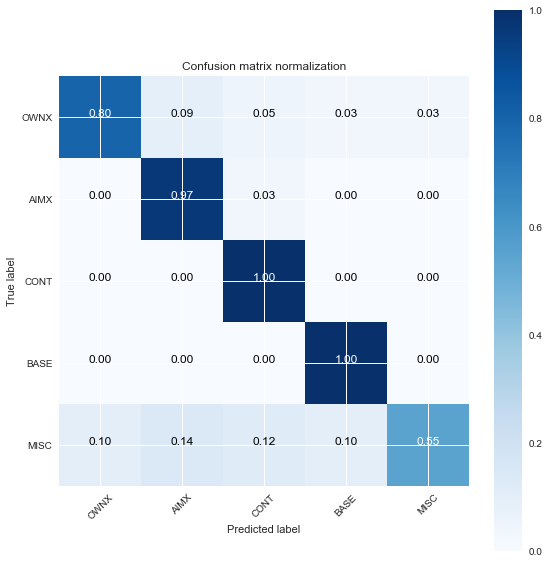

MNBCount
Mean CV LogLoss: 0.286
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.81      0.97      0.84      0.92      0.84       124
          1       0.93      0.99      0.98      0.96      0.96      0.92       125
          2       0.91      1.00      0.98      0.95      0.96      0.90       125
          3       0.98      1.00      1.00      0.99      0.99      0.98       125
          4       0.86      0.78      0.97      0.82      0.90      0.81       124

avg / total       0.91      0.92      0.98      0.91      0.95      0.89       623



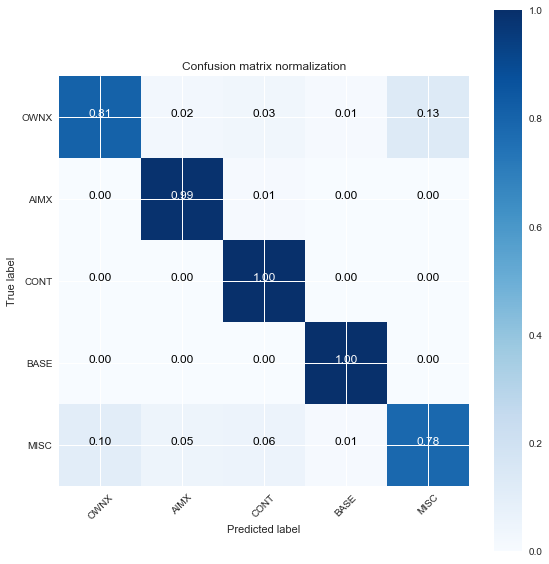

BCTFidf
Mean CV LogLoss: 0.699
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.76      0.98      0.82      0.91      0.83       124
          1       0.94      0.98      0.98      0.96      0.97      0.93       125
          2       0.95      0.98      0.99      0.97      0.97      0.95       125
          3       0.99      0.99      1.00      0.99      0.99      0.99       125
          4       0.82      0.88      0.95      0.85      0.89      0.78       124

avg / total       0.92      0.92      0.98      0.92      0.95      0.90       623



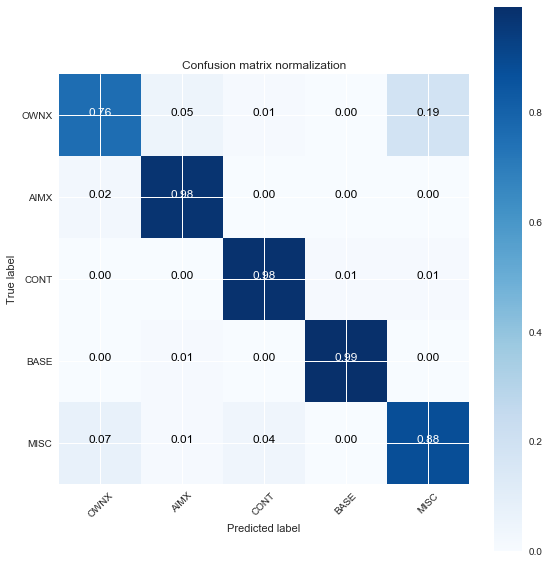

BCCount
Mean CV LogLoss: 0.808
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.79      0.97      0.82      0.90      0.81       124
          1       0.97      0.98      0.99      0.98      0.98      0.96       125
          2       0.97      0.98      0.99      0.97      0.98      0.96       125
          3       0.93      0.99      0.98      0.96      0.96      0.92       125
          4       0.88      0.87      0.97      0.87      0.92      0.84       124

avg / total       0.92      0.92      0.98      0.92      0.95      0.90       623



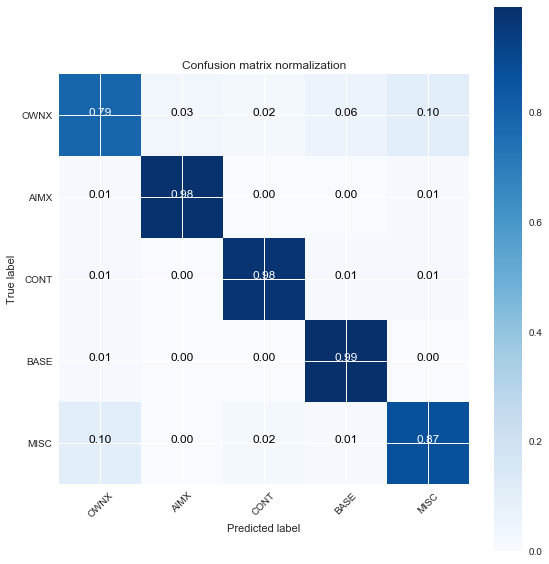

RFTFidf
Mean CV LogLoss: 0.233
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.80      0.98      0.86      0.94      0.88       124
          1       0.99      0.99      1.00      0.99      0.99      0.99       125
          2       0.99      1.00      1.00      1.00      1.00      0.99       125
          3       1.00      0.99      1.00      1.00      1.00      1.00       125
          4       0.83      0.94      0.95      0.88      0.90      0.81       124

avg / total       0.95      0.95      0.99      0.95      0.97      0.93       623



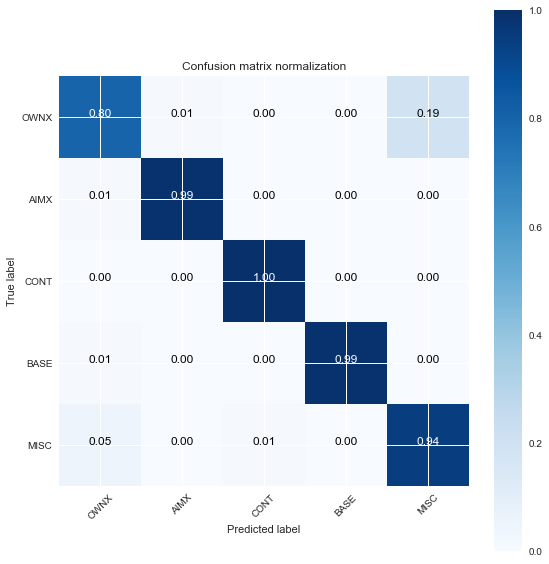

RFCount
Mean CV LogLoss: 0.216
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.85      0.97      0.87      0.93      0.85       124
          1       0.98      1.00      1.00      0.99      0.99      0.98       125
          2       1.00      0.99      1.00      1.00      1.00      1.00       125
          3       1.00      1.00      1.00      1.00      1.00      1.00       125
          4       0.87      0.90      0.97      0.88      0.92      0.84       124

avg / total       0.95      0.95      0.99      0.95      0.97      0.93       623



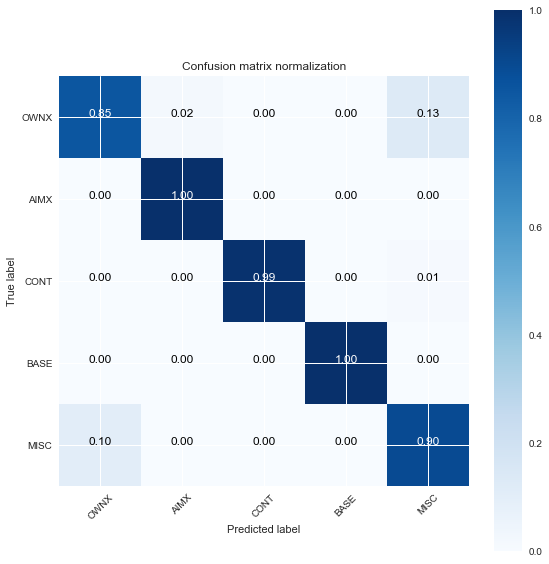

KNNTFidf
Mean CV LogLoss: 4.991
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.79      0.96      0.82      0.90      0.79       124
          1       0.67      1.00      0.88      0.80      0.82      0.65       125
          2       0.77      1.00      0.92      0.87      0.88      0.75       125
          3       0.81      1.00      0.94      0.90      0.90      0.80       125
          4       1.00      0.03      1.00      0.06      0.90      0.82       124

avg / total       0.82      0.77      0.94      0.69      0.88      0.76       623



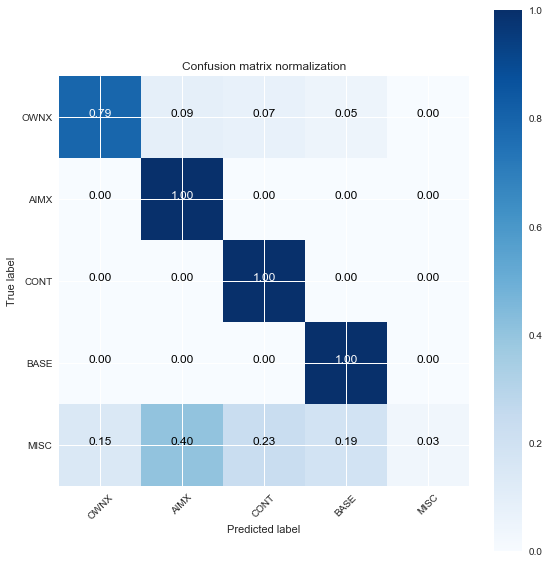

KNNCount
Mean CV LogLoss: 4.069
                   pre       rec       spe        f1       geo       iba       sup

          0       0.54      0.91      0.81      0.68      0.73      0.51       124
          1       0.91      1.00      0.97      0.95      0.95      0.90       125
          2       0.91      1.00      0.98      0.95      0.96      0.90       125
          3       0.94      1.00      0.98      0.97      0.97      0.93       125
          4       0.86      0.05      1.00      0.09      0.83      0.70       124

avg / total       0.83      0.79      0.95      0.73      0.89      0.79       623



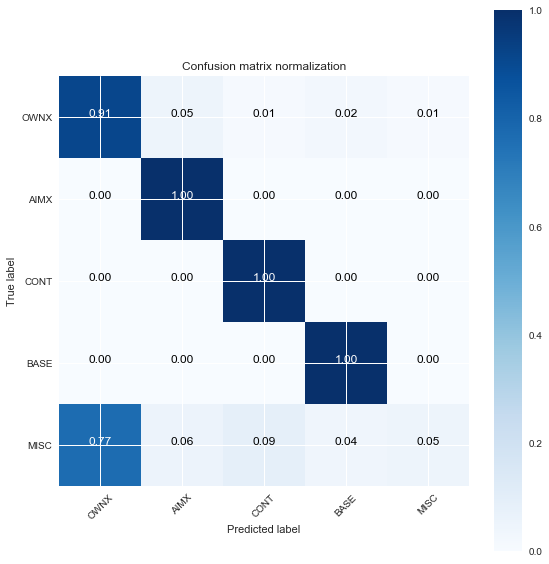

ADATFidf
Mean CV LogLoss: 1.191
                   pre       rec       spe        f1       geo       iba       sup

          0       0.42      0.49      0.83      0.45      0.60      0.35       124
          1       0.95      0.48      0.99      0.64      0.92      0.85       125
          2       0.58      0.45      0.92      0.51      0.71      0.49       125
          3       1.00      0.89      1.00      0.94      0.99      0.98       125
          4       0.40      0.68      0.75      0.51      0.60      0.35       124

avg / total       0.67      0.60      0.90      0.61      0.77      0.60       623



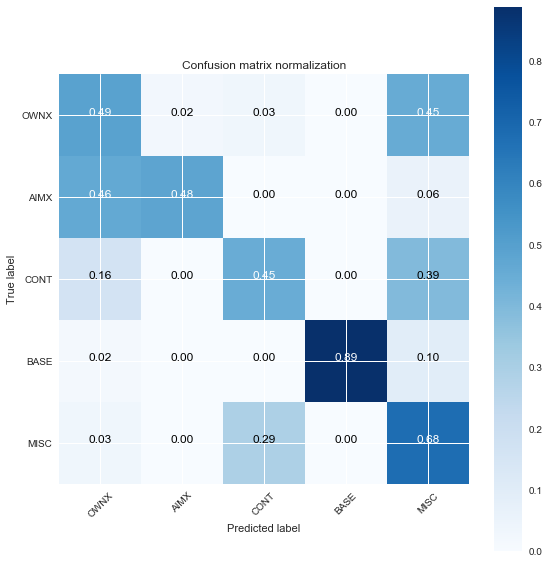

ADACount
Mean CV LogLoss: 1.212
                   pre       rec       spe        f1       geo       iba       sup

          0       0.55      0.46      0.91      0.50      0.69      0.47       124
          1       0.89      0.73      0.98      0.80      0.91      0.83       125
          2       0.82      0.69      0.96      0.75      0.87      0.75       125
          3       0.98      0.98      1.00      0.98      0.99      0.98       125
          4       0.54      0.83      0.83      0.66      0.72      0.50       124

avg / total       0.76      0.74      0.93      0.74      0.84      0.70       623



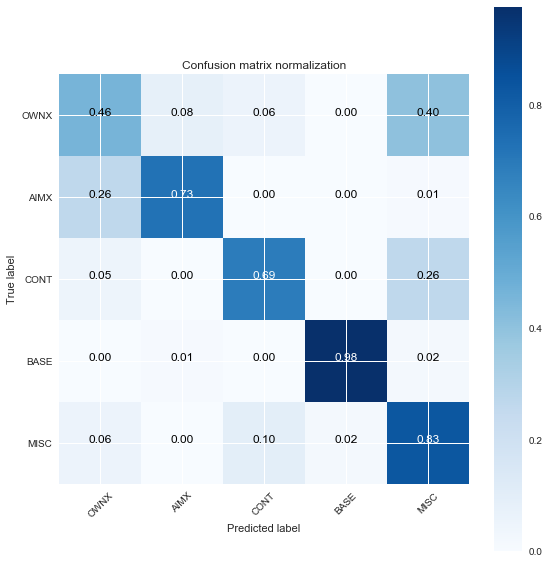

In [44]:
RANDOM_STATE = 2018
# Stacking
#X = train.drop(columns=['labels','texts','text_cleaned'])
vectorizers = [TfidfVectorizer(), CountVectorizer()]
resampler = SMOTETomek(random_state=RANDOM_STATE)

# TFidf
vectorizer = vectorizers[0]
y = labeled3['labels']
textdata = labeled3['text_cleaned'].append(unlabeled['text_cleaned']) 
full_vec = vectorizer.fit_transform(textdata)
test_vec1 = vectorizer.transform(unlabeled['text_cleaned'])
train_vec = vectorizer.transform(labeled3['text_cleaned'])

print('Original dataset shape {}'.format(Counter(y)))
# resample training data and validation sets
X_res1, y_res1 = resampler.fit_sample(train_vec, y)
print('Resampled dataset shape {}'.format(Counter(y_res1)))

# Count
vectorizer = vectorizers[1]
y = labeled3['labels']
textdata = labeled3['text_cleaned'].append(unlabeled['text_cleaned']) 
full_vec = vectorizer.fit_transform(textdata)
test_vec2 = vectorizer.transform(unlabeled['text_cleaned'])
train_vec = vectorizer.transform(labeled3['text_cleaned'])

print('Original dataset shape {}'.format(Counter(y)))
# resample training data and validation sets
X_res2, y_res2 = resampler.fit_sample(train_vec, y)
print('Resampled dataset shape {}'.format(Counter(y_res2)))

# create a function to fill the predictions feature 
train_1 = pd.DataFrame(y_res1, columns=['labels'])
test_1 = pd.DataFrame()
train_2 = pd.DataFrame(y_res2, columns=['labels'])
test_2 = pd.DataFrame()

estimators = [MultinomialNB(), 
             BaggingClassifier(n_jobs=-1, random_state=RANDOM_STATE),
             RandomForestClassifier(n_jobs=-1, class_weight="balanced"),
             KNeighborsClassifier(),
             AdaBoostClassifier(random_state=RANDOM_STATE)]
prefix_est = ['MNB', 'BC', 'RF','KNN','ADA']

for i, est in enumerate(estimators):
    name = prefix_est[i]
    # TfidfVectorizer
    print(name + 'TFidf')
    train_1, test_1 = stack_ensemble(est, X_res1, y_res1, test_vec1, train_1, test_1, name, plot=True)
    # CountVectorizer
    print(name + 'Count')
    train_2, test_2 = stack_ensemble(est, X_res2, y_res2, test_vec2, train_2, test_2, name, plot=True)

## 4.2 XGBoost Stacking and Parameter Tuning

After all the machine learning, it is obvious for this data that CountVectorizer do wells compared to the TfidfVectorier. The second last step is to stack all this information and boost it with XGBoost. The final step is to use the XGBoost to predict the unlabeled parts.

In stacking, we can combine any models and usually it will improve the quality of the predictions. By combining multiple model, it would not make the solution prone to overfitting, since it will be using the joint opinion of different models. Different models will have, more or less, different oppinions on different cases and and they will be "averaged out". The idea of stacking weak learners is that weak learners are fast to learn, so you can easily train huge amounts of such models. It appears that a huge crowd of weak learners works remarkedly well and good enough not to waste resources on combining the computationally demanding models.

**Note**: boosting and hyperparameter tuning can also result in overfitting.

In [45]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, feat_imp=True, plot=True):
    """
    This function:
        - computes XGBoost
        - plot feature importances
        - return prediction as new features
    """   
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 5
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['labels'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds, as_pandas=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    # fit the algorithm on the data
    alg.fit(dtrain[predictors],dtrain['labels'],eval_metric="mlogloss")
     
    # predict training set
    dtrain_predictions = alg.predict_proba(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    # print output
    print('Mean CV LogLoss: {:.3f}'.format(log_loss(dtrain['labels'], dtrain_predictions)))
    print(classification_report_imbalanced(dtrain['labels'], np.argmax(dtrain_predictions, axis=1)))
    
    # plot feature importance
    if feat_imp == True:
        feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Scores')

    # plot confusion matrix
    if plot == True:
        # plot confusion matrix
        cnf_matrix = confusion_matrix(dtrain['labels'], np.argmax(dtrain_predictions, axis=1))
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure(figsize=(8,8))
        plot_confusion_matrix(cnf_matrix, classes=['OWNX', 'AIMX', 'CONT', 'BASE', 'MISC'], 
                              normalize = True, title='Confusion matrix normalization')
        plt.show()

### 4.2.1 Fix Learning rate and number of estimators for tuning tree-based parameters

Mean CV LogLoss: 0.021
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      1.00      0.99      1.00      0.99       620
          1       1.00      1.00      1.00      1.00      1.00      1.00       625
          2       1.00      1.00      1.00      1.00      1.00      1.00       625
          3       1.00      1.00      1.00      1.00      1.00      1.00       625
          4       0.99      0.99      1.00      0.99      1.00      0.99       620

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      3115



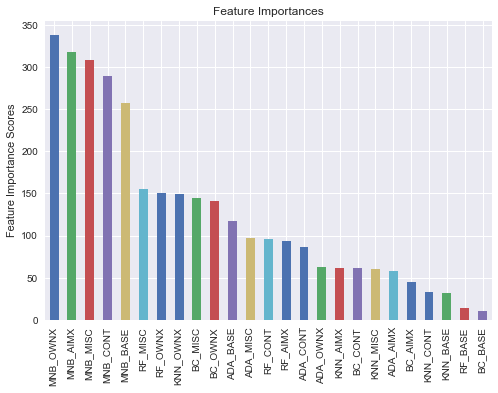

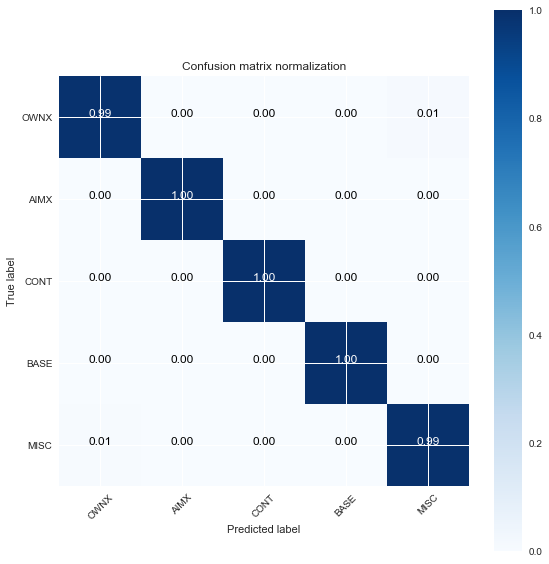

In [46]:
# Preditors, baseline models and parameters
predictors = [x for x in train_1.columns if x not in ['labels']]
xgb1 = xgb.XGBClassifier(
learning_rate=0.1,
n_estimators=125,
max_depth=5,
min_child_weight=1,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective='multi:softprob',
nthread=4,
scale_pos_weight=1,
seed=2018)

# train_1
modelfit(xgb1, train_1, predictors)

### 4.2.2 Tune max_depth and min_child_weight

In [47]:
param_test1 = {
 'max_depth':range(0,5,1),
 'min_child_weight':range(0,5,1)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=125, 
                                                      gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softprob',
                                                      nthread=4, scale_pos_weight=1, seed=2018), 
                        param_grid = param_test1, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_1[predictors],train_1['labels'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 0},
  mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 1},
  mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 2},
  mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 3},
  mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 4},
  mean: 0.96048, std: 0.02194, params: {'max_depth': 1, 'min_child_weight': 0},
  mean: 0.96048, std: 0.02194, params: {'max_depth': 1, 'min_child_weight': 1},
  mean: 0.96018, std: 0.02314, params: {'max_depth': 1, 'min_child_weight': 2},
  mean: 0.96082, std: 0.02217, params: {'max_depth': 1, 'min_child_weight': 3},
  mean: 0.96049, std: 0.02191, params: {'max_depth': 1, 'min_child_weight': 4},
  mean: 0.96014, std: 0.02435, params: {'max_depth': 2, 'min_child_weight': 0},
  mean: 0.96077, std: 0.02414, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.96177, std: 0.02425, params: {

The ideal values are 4 for **max_depth** and 0 for **min_child_weight**.

Mean CV LogLoss: 0.012
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00       620
          1       1.00      1.00      1.00      1.00      1.00      1.00       625
          2       1.00      1.00      1.00      1.00      1.00      1.00       625
          3       1.00      1.00      1.00      1.00      1.00      1.00       625
          4       1.00      1.00      1.00      1.00      1.00      1.00       620

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      3115



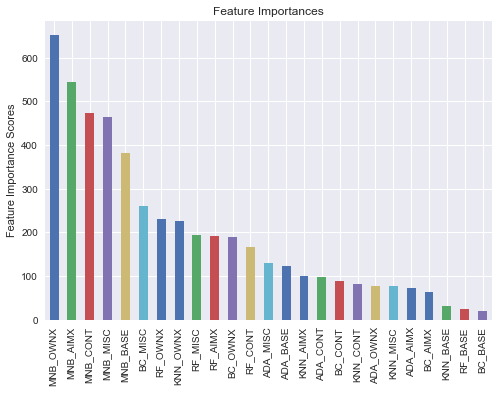

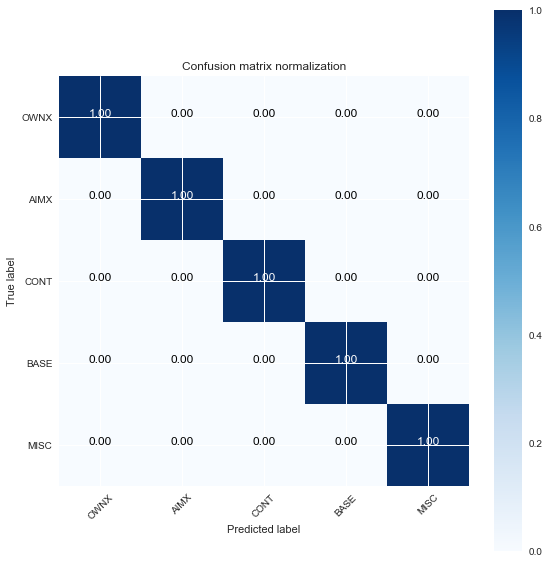

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 0},
  mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 1},
  mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 2},
  mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 3},
  mean: 0.06706, std: 0.00000, params: {'max_depth': 0, 'min_child_weight': 4},
  mean: 0.96048, std: 0.02194, params: {'max_depth': 1, 'min_child_weight': 0},
  mean: 0.96048, std: 0.02194, params: {'max_depth': 1, 'min_child_weight': 1},
  mean: 0.96018, std: 0.02314, params: {'max_depth': 1, 'min_child_weight': 2},
  mean: 0.96082, std: 0.02217, params: {'max_depth': 1, 'min_child_weight': 3},
  mean: 0.96049, std: 0.02191, params: {'max_depth': 1, 'min_child_weight': 4},
  mean: 0.96014, std: 0.02435, params: {'max_depth': 2, 'min_child_weight': 0},
  mean: 0.96077, std: 0.02414, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.96177, std: 0.02425, params: {

In [48]:
modelfit(gsearch1.best_estimator_, train_1, predictors)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

### 4.2.3 Tune Gamma

In [49]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=125, max_depth=4, min_child_weight=0, 
                                                      gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softprob',
                                                      nthread=4, scale_pos_weight=1, seed=2018), 
                        param_grid = param_test2, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_1[predictors],train_1['labels'])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.96368, std: 0.02131, params: {'gamma': 0.0},
  mean: 0.96306, std: 0.02079, params: {'gamma': 0.1},
  mean: 0.96307, std: 0.02012, params: {'gamma': 0.2},
  mean: 0.96402, std: 0.02084, params: {'gamma': 0.3},
  mean: 0.96369, std: 0.01997, params: {'gamma': 0.4},
  mean: 0.96305, std: 0.02002, params: {'gamma': 0.5},
  mean: 0.96177, std: 0.02067, params: {'gamma': 0.6},
  mean: 0.96208, std: 0.02030, params: {'gamma': 0.7},
  mean: 0.96240, std: 0.02068, params: {'gamma': 0.8},
  mean: 0.96242, std: 0.02172, params: {'gamma': 0.9}],
 {'gamma': 0.3},
 0.96401777977754577)

Best gamma is 0.1. Update the XGBoostClassifier.

Mean CV LogLoss: 0.028
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.97      1.00      0.98      0.99      0.98       620
          1       1.00      1.00      1.00      1.00      1.00      1.00       625
          2       1.00      1.00      1.00      1.00      1.00      1.00       625
          3       1.00      1.00      1.00      1.00      1.00      1.00       625
          4       0.97      0.99      0.99      0.98      0.99      0.97       620

avg / total       0.99      0.99      1.00      0.99      0.99      0.99      3115



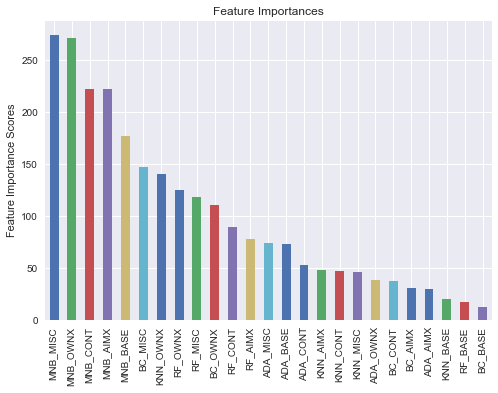

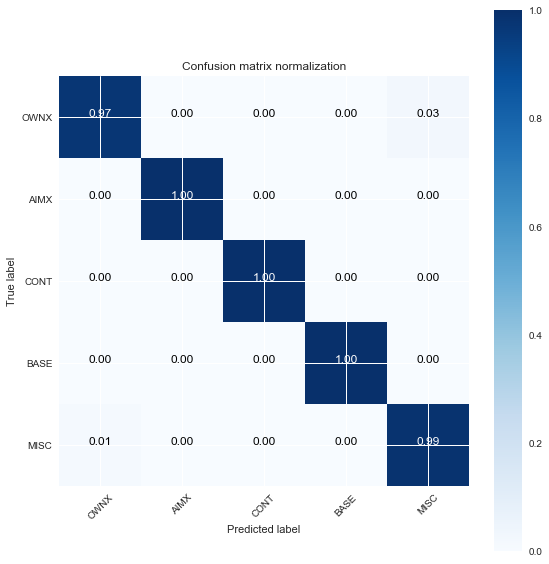

In [50]:
xgb2 = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=125, 
    max_depth=4, 
    min_child_weight=0, 
    gamma=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    objective='multi:softprob',
    nthread=4, 
    scale_pos_weight=1, 
    seed=2018)
modelfit(xgb2, train_1, predictors)

### 4.2.4 Tune subsample and colsample_bytree

In [51]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=125, max_depth=4,
 min_child_weight=0, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=2018), 
 param_grid = param_test3, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_1[predictors],train_1['labels'])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.96203, std: 0.02245, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.96237, std: 0.02151, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.96363, std: 0.02122, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.96205, std: 0.01982, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.96365, std: 0.02066, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.96169, std: 0.02079, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.96234, std: 0.02145, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.96171, std: 0.02154, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.96495, std: 0.02120, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.96298, std: 0.02138, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.96306, std: 0.02079, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.96143, std: 0.02001, params: {'colsample_bytree': 0.8, 'subsample'

In [52]:
param_test3 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=125, max_depth=4,
 min_child_weight=0, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=2018), 
 param_grid = param_test3, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_1[predictors],train_1['labels'])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.96271, std: 0.01997, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.96208, std: 0.02077, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.96306, std: 0.02056, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.96365, std: 0.02058, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.96306, std: 0.02079, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.96272, std: 0.01969, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.96333, std: 0.02041, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.96304, std: 0.02194, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.96310, std: 0.02098, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.75},
 0.96365348978799548)

The ideal parameters are 0.8 for colsample_bytree and 0.8 for subsample.

Mean CV LogLoss: 0.028
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.97      1.00      0.98      0.99      0.98       620
          1       1.00      1.00      1.00      1.00      1.00      1.00       625
          2       1.00      1.00      1.00      1.00      1.00      1.00       625
          3       1.00      1.00      1.00      1.00      1.00      1.00       625
          4       0.97      0.99      0.99      0.98      0.99      0.97       620

avg / total       0.99      0.99      1.00      0.99      0.99      0.99      3115



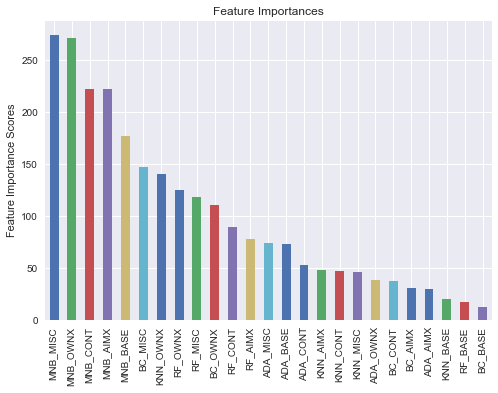

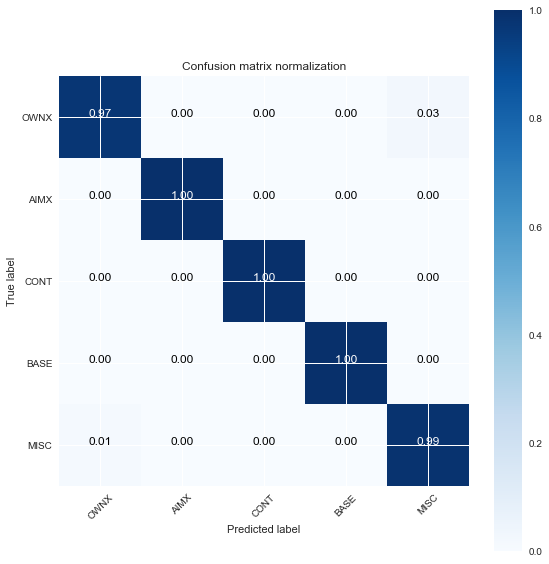

In [53]:
xgb3 = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=125, 
    max_depth=4, 
    min_child_weight=0, 
    gamma=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    objective='multi:softprob',
    nthread=4, 
    scale_pos_weight=1, 
    seed=2018)
modelfit(xgb3, train_1, predictors)

### 4.2.5 Tune Regularization parameters

In [54]:
param_test4 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=125, max_depth=4,
 min_child_weight=0, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=2018), 
 param_grid = param_test4, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_1[predictors],train_1['labels'])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.96306, std: 0.02079, params: {'reg_alpha': 1e-05},
  mean: 0.96242, std: 0.02160, params: {'reg_alpha': 0.01},
  mean: 0.96465, std: 0.02008, params: {'reg_alpha': 0.1},
  mean: 0.96209, std: 0.02172, params: {'reg_alpha': 1},
  mean: 0.95918, std: 0.02668, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.96465451385752754)

In [55]:
param_test4 = {
    'reg_alpha':[0.8e-05, 0.9e-05, 1e-05, 2e-05, 3e-05]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=125, max_depth=4,
 min_child_weight=0, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=2018), 
 param_grid = param_test4, scoring='f1_weighted',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_1[predictors],train_1['labels'])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

C:\Users\LW130003\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.96306, std: 0.02079, params: {'reg_alpha': 8e-06},
  mean: 0.96306, std: 0.02079, params: {'reg_alpha': 9e-06},
  mean: 0.96306, std: 0.02079, params: {'reg_alpha': 1e-05},
  mean: 0.96306, std: 0.02079, params: {'reg_alpha': 2e-05},
  mean: 0.96306, std: 0.02079, params: {'reg_alpha': 3e-05}],
 {'reg_alpha': 8e-06},
 0.96306325127907022)

they all have have the same mean and standard deviation, we pick 1e-05 as ideal reg_alpha.

Mean CV LogLoss: 0.028
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.97      1.00      0.98      0.99      0.98       620
          1       1.00      1.00      1.00      1.00      1.00      1.00       625
          2       1.00      1.00      1.00      1.00      1.00      1.00       625
          3       1.00      1.00      1.00      1.00      1.00      1.00       625
          4       0.97      0.99      0.99      0.98      0.99      0.97       620

avg / total       0.99      0.99      1.00      0.99      0.99      0.99      3115



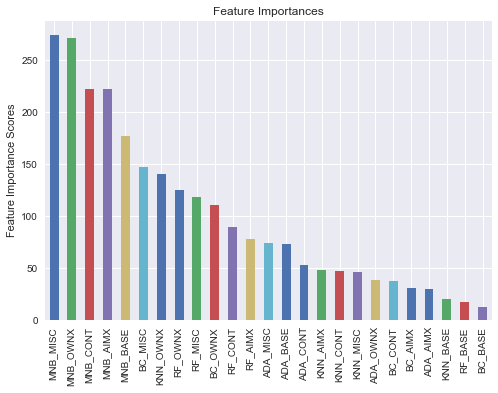

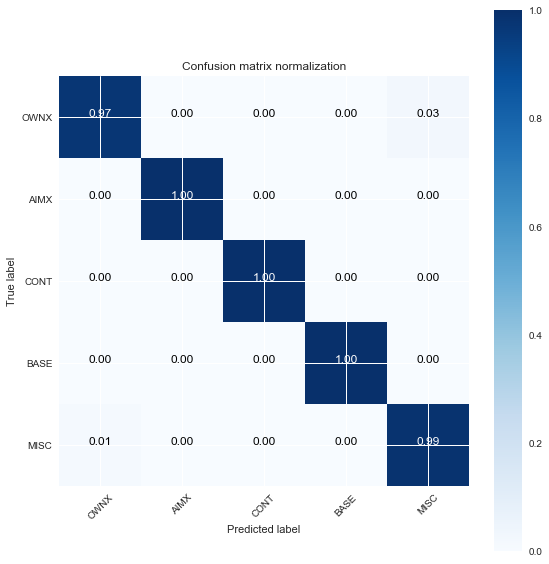

In [56]:
xgb4 = xgb.XGBClassifier(
    learning_rate=0.1, 
    n_estimators=125, 
    max_depth=4, 
    min_child_weight=0, 
    gamma=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    reg_alpha=1e-05,
    objective='multi:softprob',
    nthread=4, 
    scale_pos_weight=1, 
    seed=2018)
modelfit(xgb4, train_1, predictors)

### 4.2.6 Reducing Learning Rate
In this section, we will reduce learning_rate and increase n_estimators.

Mean CV LogLoss: 0.027
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.98      1.00      0.98      0.99      0.98       620
          1       1.00      1.00      1.00      1.00      1.00      1.00       625
          2       1.00      1.00      1.00      1.00      1.00      1.00       625
          3       1.00      1.00      1.00      1.00      1.00      1.00       625
          4       0.98      0.99      0.99      0.98      0.99      0.97       620

avg / total       0.99      0.99      1.00      0.99      1.00      0.99      3115



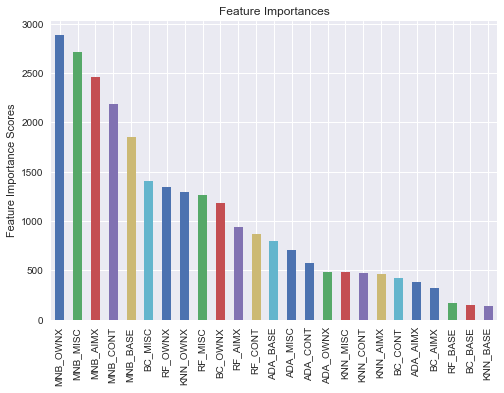

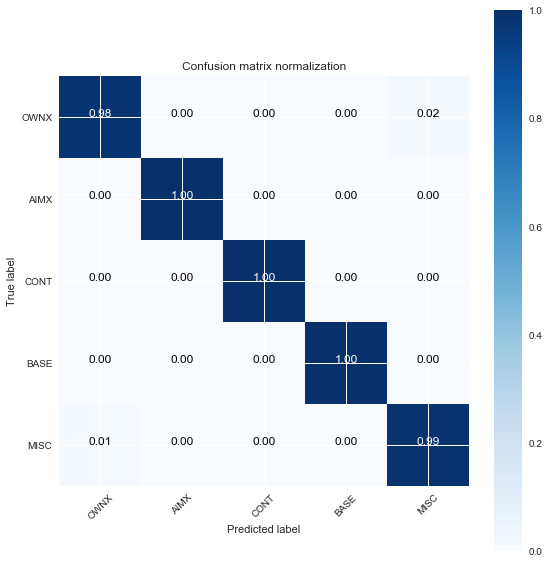

In [57]:
xgb5 = xgb.XGBClassifier(
    learning_rate=0.01, 
    n_estimators=5000, 
    max_depth=4, 
    min_child_weight=0, 
    gamma=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    reg_alpha=1e-05,
    objective='multi:softprob',
    nthread=4, 
    scale_pos_weight=1, 
    seed=2018)
modelfit(xgb5, train_1, predictors)

**Before and After Boosting**

In [58]:
# Before Boosting
estimator = xgb1
# fit algorithm on the data
estimator.fit(train_1[predictors], train_1['labels'])
test_1_pred = estimator.predict(test_1[predictors])
pd.Series(test_1_pred).value_counts()

4    23524
0     7705
1     2430
2      781
3      155
dtype: int64

In [59]:
# After Boosting
estimator = xgb5
# fit algorithm on the data
estimator.fit(train_1[predictors], train_1['labels'])
test_1_pred = estimator.predict(test_1[predictors])

In [60]:
pred = pd.Series(test_1_pred)
pred.value_counts()

4    23863
0     8597
1     1578
2      402
3      155
dtype: int64

In [61]:
reremap1 = {0: 'OWNX', 1: 'AIMX', 2: 'CONT', 3: 'BASE', 4: 'MISC'}
pred.replace(reremap1, inplace=True)    
pred.value_counts()

MISC    23863
OWNX     8597
AIMX     1578
CONT      402
BASE      155
dtype: int64

# 5. Submission
Predict test and creating submission files.

In [65]:
submission = pd.DataFrame({
"texts": unlabeled["texts"].values,
"labels": pred.values
})
submission.to_csv(r'C:\Users\LW130003\Desktop\New folder\SentenceCorpus\submission.csv', index=False)